In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import pickle

In [2]:
IMAGES_LOCATION="datasets/images/"

df=pd.read_csv("datasets/styles.csv", error_bad_lines=False, warn_bad_lines=False)
df=df.dropna().reset_index(drop=True)
df["image_name"]=df.apply(lambda row: str(row["id"])+".jpg",axis=1).reset_index(drop=True)
image_files=os.listdir(IMAGES_LOCATION)
print(df.shape)
df=df[df["image_name"].isin(image_files)].reset_index(drop=True)
df=df.groupby("articleType").filter(lambda x : len(x)>2000).reset_index(drop=True)
print(df.groupby("articleType").count())
print(df.shape)

(44077, 11)
                id  gender  masterCategory  subCategory  baseColour  season  \
articleType                                                                   
Casual Shoes  2845    2845            2845         2845        2845    2845   
Shirts        3212    3212            3212         3212        3212    3212   
Sports Shoes  2016    2016            2016         2016        2016    2016   
Tshirts       7065    7065            7065         7065        7065    7065   
Watches       2542    2542            2542         2542        2542    2542   

              year  usage  productDisplayName  image_name  
articleType                                                
Casual Shoes  2845   2845                2845        2845  
Shirts        3212   3212                3212        3212  
Sports Shoes  2016   2016                2016        2016  
Tshirts       7065   7065                7065        7065  
Watches       2542   2542                2542        2542  
(17680, 11)


In [3]:
df["articleType"]=df["articleType"].astype("category")
df["articleType_cat"]=df["articleType"].cat.codes
df

def create_training_data(df):
    training_data=[]
    path=IMAGES_LOCATION
    count=0
    for img in df["image_name"]:
            category=df[df["image_name"]==str(img)]["articleType_cat"].values[0]
            img_array= cv2.imread(os.path.join(path,img))
            img_array=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            img_array=cv2.resize(img_array, (60,80))
            training_data.append([img_array, category])
    return training_data

import random
training_data=create_training_data(df)
random.shuffle(training_data)

len(training_data)

17680

In [4]:
training_data

[[array([[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         ...,
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255

In [5]:
x=[]
y=[]

for features, labels in training_data:
    x.append(features)
    y.append(labels)
    
x=np.array(x).reshape(-1,80,60,3)
y=np.array(y)

print(y)
# feature_name="gray_features.pickle"
# label_name="gray_labels.pickle"

feature_name="features.pickle"
label_name="labels.pickle"

pickle_out = open(feature_name,"wb")
pickle.dump(x,pickle_out)
pickle_out.close()

pickle_out = open(label_name,"wb")
pickle.dump(y,pickle_out)
pickle_out.close()

pickle_in = open(feature_name,"rb")
features_set=pickle.load(pickle_in)
pickle_in.close()

pickle_in = open(label_name,"rb")
labels_set=pickle.load(pickle_in)
pickle_in.close()

[3 3 3 ... 3 0 0]


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_set, labels_set, test_size=0.2, shuffle=True, random_state=1)
print("Train data shape: {}.".format(x_train.shape))
print("Test data shape {}.".format(x_test.shape))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]


Train data shape: (14144, 80, 60, 3).
Test data shape (3536, 80, 60, 3).


(<matplotlib.image.AxesImage at 0x7fce6afd70b8>,
 4,
 id                                       59263
 gender                                   Women
 masterCategory                     Accessories
 subCategory                            Watches
 articleType                            Watches
 baseColour                              Silver
 season                                  Winter
 year                                      2016
 usage                                   Casual
 productDisplayName    Titan Women Silver Watch
 image_name                           59263.jpg
 articleType_cat                              4
 Name: 1, dtype: object)

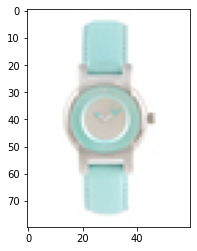

In [7]:
i=13
plt.imshow(x_train[i]), y_train[i], df[df["articleType_cat"]==y_train[i]].iloc[0]

In [8]:
min(df.groupby("articleType_cat").count()["id"])

2016

In [9]:
'''Trains a Siamese MLP on pairs of digits from the MNIST dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for more details).
# References
- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU
'''
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 5
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255
# input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Epoch 1/20
127/127 [==============================] - 3s 27ms/step - loss: 14.9458 - accuracy: 0.5085 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 2/20
127/127 [==============================] - 3s 25ms/step - loss: 0.6019 - accuracy: 0.5121 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 3/20
127/127 [==============================] - 3s 26ms/step - loss: 0.4997 - accuracy: 0.5005 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 4/20
127/127 [==============================] - 4s 29ms/step - loss: 0.4997 - accuracy: 0.5001 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 5/20
127/127 [==============================] - 4s 28ms/step - loss: 0.4997 - accuracy: 0.5005 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 6/20
127/127 [==============================] - 3s 27ms/step - loss: 0.4997 - accuracy: 0.5009 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 7/20
127/127 [==============================] - 3s 26ms/step - loss: 0.4997 - accuracy: 0.5000 - val_loss: 0.4997 - val_accuracy: 0.500

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]
x_train.shape

(60000, 28, 28)

In [11]:
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
digit_indices

[array([    1,    21,    34, ..., 59952, 59972, 59987]),
 array([    3,     6,     8, ..., 59979, 59984, 59994]),
 array([    5,    16,    25, ..., 59983, 59985, 59991]),
 array([    7,    10,    12, ..., 59978, 59980, 59996]),
 array([    2,     9,    20, ..., 59943, 59951, 59975])]

In [12]:
tr_pairs

array([[[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         ...,

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1.